# Download several PPI resources and combine them into a single tsv

In [1]:
import zipfile
import io
import itertools

import pandas
import numpy
import seaborn

%matplotlib inline

In [2]:
def order_genes_in_df(df):
    gene_0 = numpy.minimum(df.gene_0, df.gene_1)
    gene_1 = numpy.maximum(df.gene_0, df.gene_1)
    df.gene_0, df.gene_1 = gene_0, gene_1
    df = df.drop_duplicates()
    return df

In [3]:
%%capture
# Download sources
! wget --timestamping --directory-prefix download/hid/ http://interactome.dfci.harvard.edu/H_sapiens/download/HI-II-14.tsv
! wget --timestamping --directory-prefix download/hid/ http://interactome.dfci.harvard.edu/H_sapiens/download/Lit-BM-13.tsv
! wget --timestamping --directory-prefix download/ii/ http://www.sciencemag.org/content/suppl/2015/02/18/347.6224.1257601.DC1/Datasets_S1-S4.zip

In [4]:
columns = ['gene_0', 'gene_1', 'source']

## Incomplete Interactome

In [5]:
with zipfile.ZipFile('download/ii/Datasets_S1-S4.zip') as zip_file:
    with zip_file.open('data/DataS1_interactome.tsv', 'r') as read_file:
        ii_df = pandas.read_table(read_file, comment='#', names=['gene_0', 'gene_1', 'sources'])

ii_df.tail()

,gene_0,gene_1,sources
141291,65005,84311,complexes
141292,4750,7249,binary;literature;signaling
141293,4644,90427,literature
141294,204851,2275,binary
141295,116173,8803,binary


In [6]:
rows = list()

for i, (gene_0, gene_1, sources) in ii_df.iterrows():
    sources = sources.split(';')
    for source in sources:
        row = gene_0, gene_1, 'II_{}'.format(source)
        rows.append(row)

ii_df = pandas.DataFrame(rows, columns=columns)
ii_df = order_genes_in_df(ii_df)
ii_df.tail(2)

,gene_0,gene_1,source
193708,2275,204851,II_binary
193709,8803,116173,II_binary


## Human Interactome Database

In [7]:
systematic_df = pandas.read_table('download/hid/HI-II-14.tsv')
systematic_df = systematic_df[['Entrez Gene IDA', 'Entrez Gene IDB']]
systematic_df['source'] = 'HI-II-14'
systematic_df.columns = columns
systematic_df = order_genes_in_df(systematic_df)
len(systematic_df)

13944

In [8]:
literature_df = pandas.read_table('download/hid/Lit-BM-13.tsv')
literature_df = literature_df[['entrez_gene_ida', 'entrez_gene_idb']]
literature_df['source'] = 'Lit-BM-13'
literature_df.columns = columns
literature_df = order_genes_in_df(literature_df)
len(literature_df)

11045

## Combine

In [9]:
combined_df = pandas.concat([ii_df, systematic_df, literature_df])
combined_df = combined_df.sort(list(combined_df.columns))
len(combined_df)

218699

In [10]:
source_to_interactions = dict()
for i, (gene_0, gene_1, source) in combined_df.iterrows():
    interactions = source_to_interactions.setdefault(source, set())
    interactions.add(frozenset((gene_0, gene_1)))

In [11]:
# Interactions per resource
{k: len(v) for k, v in source_to_interactions.items()}

{'HI-II-14': 13944,
 'II_binary': 28653,
 'II_complexes': 31276,
 'II_kinase': 6066,
 'II_literature': 88349,
 'II_metabolic': 5325,
 'II_regulatory': 1335,
 'II_signaling': 32706,
 'Lit-BM-13': 11045}

In [12]:
# What percent of the interactions from the row source are in the interactions from the column source
rows = []
for source_0, source_1 in itertools.product(source_to_interactions, repeat=2):
    source_0_genes = source_to_interactions[source_0]
    intersect = source_0_genes & source_to_interactions[source_1]
    rows.append((source_0, source_1, len(intersect) / len(source_0_genes)))

overlap_df = pandas.DataFrame(rows, columns=['source_0', 'source_1', 'coverage'])
overlap_df = overlap_df.pivot('source_0', 'source_1', 'coverage')
numpy.round(overlap_df * 100, 2)

source_1,HI-II-14,II_binary,II_complexes,II_kinase,II_literature,II_metabolic,II_regulatory,II_signaling,Lit-BM-13
source_0,,,,,,,,,
HI-II-14,100.00,100.00,0.85,0.09,9.19,0.01,0.00,4.79,2.94
II_binary,48.67,100.00,1.70,0.69,49.01,0.01,0.04,27.42,9.96
II_complexes,0.38,1.56,100.00,0.24,23.52,0.05,0.01,4.68,2.90
II_kinase,0.20,3.25,1.24,100.00,32.00,0.00,0.03,24.81,4.39
II_literature,1.45,15.89,8.32,2.20,100.00,0.04,0.07,32.55,9.78
II_metabolic,0.04,0.08,0.32,0.00,0.66,100.00,0.00,0.24,0.08
II_regulatory,0.00,0.82,0.15,0.15,4.79,0.00,100.00,3.37,1.20
II_signaling,2.04,24.02,4.48,4.60,87.94,0.04,0.14,100.00,15.51
Lit-BM-13,3.71,25.83,8.20,2.41,78.21,0.04,0.14,45.93,100.00


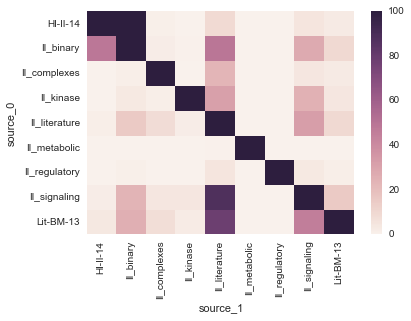

In [13]:
seaborn.heatmap(overlap_df * 100);

In [14]:
combined_df.to_csv('data/ppi-sources.tsv', index=False, sep='\t')